In [5]:
# This notebook contains the code for training a Functional API model.
# The best model from this training is saved as "model_functional.h5".
# This notebook is used to experiment with the Functional API model type and train a model compatible with GradCAM heatmap visualization.
# The model produced here does not in any way go towards the official project model submission, this is just for further exploration.

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np

In [2]:
# Hyperparameters
epochs = 100
batch_train_size = 16
batch_size = 15
initial_learning_rate = 1.5e-4
l2_regularize = 1.5e-5
l1_regularize = 1e-6

con_layer = 4
con_filters = "(64,128,256,512)"
dense_layer = 3
drop_out_rate = "(0.1,0.1,0.1)"
dense_filters = "(64,32,16)"
regularizer = 4
data_aug = True

# Directories
root = 'C:/Users/kahny/ML Model'
train_dir = os.path.join(root, 'Train_Resized/')
val_dir = os.path.join(root, 'Validate_Resized/')
test_dir = os.path.join(root, 'Test_Resized/')

In [3]:
# Image Data Generators with Augmentation
def image_gen_w_aug(train_parent_directory, validate_parent_directory, test_parent_directory):
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       rotation_range=45,
                                       zoom_range=0.3,
                                       width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       shear_range=0.3,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1/255)
    val_datagen = ImageDataGenerator(rescale=1/255)

    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                        target_size=(75, 75),
                                                        batch_size=batch_train_size,
                                                        class_mode='categorical',
                                                        shuffle=True)

    val_generator = val_datagen.flow_from_directory(validate_parent_directory,
                                                    target_size=(75, 75),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                                      target_size=(75, 75),
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=False)

    return train_generator, val_generator, test_generator

# Define an Inception Module
def inception_module(x, filters):
    f1, f2, f3, f4 = filters

    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    conv3 = Conv2D(f2[0], (1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f2[1], (3, 3), padding='same', activation='relu')(conv3)

    conv5 = Conv2D(f3[0], (1, 1), padding='same', activation='relu')(x)
    conv5 = Conv2D(f3[1], (5, 5), padding='same', activation='relu')(conv5)

    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(f4, (1, 1), padding='same', activation='relu')(pool)

    out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return out

# Build the Model
def build_model(input_shape):
    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)

    x = inception_module(x, [32, (48, 64), (8, 16), 16])
    x = MaxPooling2D((2, 2))(x)

    x = inception_module(x, [64, (96, 128), (16, 32), 32])
    x = MaxPooling2D((2, 2))(x)

    x = inception_module(x, [128, (128, 192), (32, 96), 64])
    x = MaxPooling2D((2, 2))(x)

    x = inception_module(x, [128, (128, 192), (32, 96), 64])
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_regularize, l2=l2_regularize))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_regularize, l2=l2_regularize))(x)
    x = Dropout(0.2)(x)

    output_layer = Dense(3, activation='softmax')(x)

    model = Model(input_layer, output_layer)
    return model

# Custom Callback to Stop Training Early
class CustomStopper(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and val_acc is not None:
            if train_acc >= 0.97 and val_acc >= 0.97:
                print(f"\nStopping training as both train and val accuracy have reached 97%.")
                self.model.stop_training = True

# Generate Image Data
train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, val_dir, test_dir)

# Build and Compile the Model
input_shape = (75, 75, 3)
model = build_model(input_shape)
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Callbacks for Training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
custom_stopper = CustomStopper()

# Function to Convert DirectoryIterator to tf.data.Dataset
def generator_to_dataset(generator):
    output_signature = (
        tf.TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
    def generator_function():
        for batch in generator:
            yield batch
    return tf.data.Dataset.from_generator(generator_function, output_signature=output_signature)

# Convert Generators to tf.data.Dataset
train_dataset = generator_to_dataset(train_generator).repeat()
validation_dataset = generator_to_dataset(validation_generator).repeat()

# Train the Model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr, custom_stopper]
)

# Evaluate the Model on Test Data
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

# Retrieve Final Training and Validation Metrics
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
training_loss = history.history['loss'][-1]
validation_loss = history.history['val_loss'][-1]

# Print Summary of Model Performance
print(f"\nModel Summary:")
print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
print(f"Training Loss: {training_loss:.4f}")
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}\n")
print(f"Learning Rate: {initial_learning_rate}")
print(f"Epochs: {epochs}")
print(f"Steps Per Epoch: {len(train_generator)}")
print(f"Batch Size: {train_generator.batch_size}")

# Save the Model
model.save('my_model.h5')

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 75,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 37, 37,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 37, 37,    │      1,584 │ max_pooling2d[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 37, 37, 8) │        264 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 37,    │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 37, 37,    │      1,056 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 37, 37,    │     27,712 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 37, 37,    │      3,216 │ conv2d_4[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 37, 37,    │        528 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 37, 37,    │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 18, 18,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 18, 18,    │     12,384 │ max_pooling2d_2[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 18, 18,    │      2,064 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 18, 18,    │          0 │ max_pooling2d_2[… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 18, 18,    │      8,256 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,567,019 (5.98 MB)

 Trainable params: 1,567,019 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3927 - loss: 1.1095 - val_accuracy: 0.7133 - val_loss: 0.7877 - learning_rate: 1.5000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6112 - loss: 0.9037 - val_accuracy: 0.8200 - val_loss: 0.5263 - learning_rate: 1.5000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7270 - loss: 0.7046 - val_accuracy: 0.8700 - val_loss: 0.3440 - learning_rate: 1.5000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7902 - loss: 0.5718 - val_accuracy: 0.8933 - val_loss: 0.2782 - learning_rate: 1.5000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8214 - loss: 0.4811 - val_accuracy: 0.9333 - val_loss: 0.2447 - learning_rate: 1.5000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8502 - loss: 0.4021 - val_accuracy: 0.8833 - val_loss: 0.3218 - learning_rate: 1.5000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/st

C:\Users\kahny\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9873 - loss: 0.0448



Model Summary:
Training Accuracy: 0.9700
Validation Accuracy: 0.9900
Test Accuracy: 0.9867

Training Loss: 0.0964
Validation Loss: 0.0549
Test Loss: 0.0457

Learning Rate: 0.00015
Epochs: 100
Steps Per Epoch: 150
Batch Size: 16


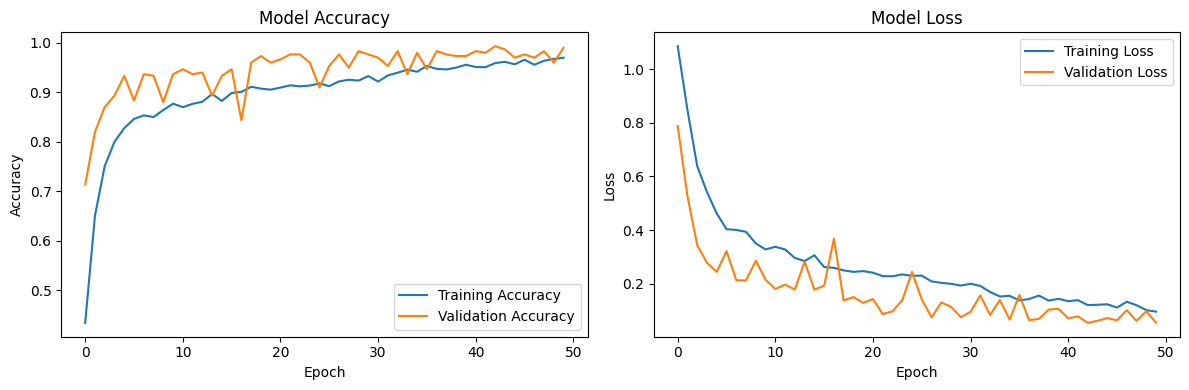

In [4]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()